<a href="https://colab.research.google.com/github/Ibrahim-Amazal/Comparative-Performance-Analysis-of-Scalable-Chicago-Crime-Analytics-Using-Apache-Spark-/blob/main/Chicago_Crime_Data_Apache_Spark_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chicago Crime Data - Apache Spark Project


####**Project summary**
This project utilizes a 7m Chicago crime dataset record which we ingested into Spark, cleaned critical nulls and duplicates, and normalised categorical fields. Also conducted exploratory analysis exposed a long‑term decline in crime (2001‑2014), a post‑COVID rebound, and clear spatial hot‑spots.

Our feature engineering focused on interpretable variables: crime type, location, domestic flag, beat and district IDs. Simpler, targeted features out‑performed an earlier high‑dimensional set that had induced over‑fitting.

**Three models were deployed:**

- **A binary Random Forest** predicting arrests (ROC‑AUC 0.85).

- **A multiclass Random Forest** classifying primary crime type (accuracy 0.38, limited by class imbalance).

- **A K‑Means model** (k = 5, silhouette 0.70) revealing coherent spatial‑category clusters.

Outputs were exported to Parquet for smooth future result utilization. The work lays a clear path for future improvements such as class‑balancing and hyper‑parameter tuning plus a more in depth comparative analysis of models in predicting similar variable.


## Project Initialization & Setup

In [ ]:
# Spark Setup
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, to_timestamp, year, month, hour

# Data Cleaning & Transformation
from pyspark.sql.functions import regexp_replace, trim

# Feature Engineering
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, MinMaxScaler, Bucketizer

# Just in case text Processing tools (Optional for text columns)
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

# Statistical Analysis
from pyspark.ml.stat import Correlation

# ML Algorithms
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.clustering import KMeans

#  Model Evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator, ClusteringEvaluator

# ML Pipeline
from pyspark.ml import Pipeline

# Hyperparameter Tuning
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Just in case  Python Utilities
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


#Data Ingestion

In [ ]:
#Import data and display
df = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("dbfs:/FileStore/shared_uploads/13131818@studentmail.ul.ie/Crimes___2001_to_Present_20250410.csv")

df.printSchema()
# Print top 5 lines to show this loads successfully
df.show(5)


root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)

+--------+-----------+--------------------+--------------------+----+--------------------+------

####_Initial Raw Data Inspection_

Before cleaning or transforming the dataset, we first explore the **original structure and distribution**. This step provides critical insights into:
- The presence of nulls or inconsistencies
- The overall scale and size of data
- Dominant crime types and locations
- The range and variance of geo and temporal fields

This helps shape **our cleaning strategy** in an informed, data-driven way.


###### _NUMERIC COLUMNS_

In [ ]:
# 1) Select only the numeric columns and drop rows with nulls
numeric_cols  = ["Latitude", "Longitude", "Year", "Beat", "Ward", "District", "X Coordinate", "Y Coordinate"]
df_numeric    = df.select(numeric_cols).dropna()

# 2) Get Spark describe output as a Pandas DataFrame
numeric_stats_raw = df_numeric.describe().toPandas()

# 3) Clean up the header & index
numeric_stats_clean = numeric_stats_raw.set_index("summary").transpose()
numeric_stats_clean.index.name = "Feature"


# 4) Promote the pandas index into a visible column
numeric_stats_clean = numeric_stats_clean.reset_index().rename(columns={"index": "Feature"})

# 5) Display
display(numeric_stats_clean)


Feature,count,mean,stddev,min,max
Latitude,7592944,41.84223499366073,0.08881116722413135,36.619446395,42.022709624
Longitude,7592944,-87.67131743273463,0.0610712819537822,-91.686565684,-87.524529378
Year,7592944,2011.5396601107554,6.59522220298005,2001,2025
Beat,7592944,1180.4069852220694,702.9659936126968,111,2535
Ward,7592944,22.77004347720726,13.855462344226634,1,50
District,7592944,11.289126589106939,6.957856065701475,1,31
X Coordinate,7592944,1164649.021001867,16840.758121669092,0,1205119
Y Coordinate,7592944,1885801.9380789585,32281.463498474433,0,1951573


###### _NON-NUMERIC COLUMNS_

In [ ]:
# Identify non-numeric columns
non_numeric_cols = [col_name for col_name, dtype in df.dtypes if dtype not in ["int", "double", "float", "bigint"]]

# Show unique counts and nulls for each non-numeric column
from pyspark.sql.functions import countDistinct, isnan

for col_name in non_numeric_cols:
    total = df.select(col_name).count()
    distinct = df.select(countDistinct(col_name)).collect()[0][0]
    nulls = df.filter((col(col_name).isNull()) | (col(col_name) == "")).count()

    print(f"\n Column: {col_name}")
    print(f"   Total Rows: {total}")
    print(f"   Unique Values: {distinct}")
    print(f"   Null/Blank Entries: {nulls}")

    # Show top 5 most frequent values
    print("   Top 5 Values:")
    df.groupBy(col_name).count().orderBy("count", ascending=False).show(5, truncate=False)



 Column: Case Number
   Total Rows: 8290373
   Unique Values: 8289782
   Null/Blank Entries: 0
   Top 5 Values:
+-----------+-----+
|Case Number|count|
+-----------+-----+
|HZ140230   |6    |
|HJ590004   |6    |
|JC470284   |5    |
|HP296582   |5    |
|HS256531   |5    |
+-----------+-----+
only showing top 5 rows



#####_Optimized Block_

In [ ]:
# 1) Cache
df.cache()
df.count()

# 2) One‑pass summary
from pyspark.sql.functions import col, count, countDistinct, when, lit

non_numeric = [c for c,t in df.dtypes if t not in ("int","double","float","bigint")]
exprs = []
for c in non_numeric:
    exprs += [
      count(lit(1)).alias(f"{c}_total"),
      countDistinct(col(c)).alias(f"{c}_distinct"),
      count(when(col(c).isNull() | (col(c) == ""), c)).alias(f"{c}_nulls"),
    ]

summary_df = df.agg(*exprs).toPandas().T
summary_df.columns = ["value"]
summary_df.index.name = "metric"
display(summary_df)

# 3) Top 5 values (cached)
for c in non_numeric:
    print(f"=== Top 5 values for {c} ===")
    df.groupBy(c).count() \
      .orderBy("count", ascending=False) \
      .limit(5) \
      .show(truncate=False)


Why We Optimized the Non‑Numeric Summary Block
When profiling non‑numeric columns-counting total rows, distinct values, nulls, and top categories-our first attempt triggered a new Spark job for each metric on each column. On a multi‑million‑row dataset, that meant dozens of full‑table scans and long wait times.

In order to fix this, we:

- Cached the DataFrame by calling df.cache() and materializing it with a single df.count(), we keep the data in memory. Subsequent operations read from RAM instead of disk, cutting I/O dramatically.

- Grouped multiple aggregates into one pass. rather than running count(), countDistinct(), and null‑checks separately for each column, we build a single .agg(...) call with all those functions at once. Spark then scans the data one time and returns every metric in one DataFrame, eliminating redundant work.

- Limited per‑column grouping to just “Top 5”: For the frequency breakdowns, we still need a separate groupBy() per column. But because the DataFrame is cached, each of those groupings runs much faster, and you only run five of them (one per non‑numeric feature) instead of dozens of count queries.

These changes transform dozens of Spark jobs into just a handful-one to cache, one to compute all aggregates, and a few for the small “Top 5” lookups which makes the notebook smoothly reusable for interactive analysis.

#Data Cleaning

The critical cleaning stage involved strategic decisions driven by exploratory data analysis. Dropping records with null values in core fields (Primary Type, Date, Latitude, and Longitude) ensured foundational data integrity crucial for meaningful spatial-temporal analysis. By systematically addressing duplicate records and handling missing textual descriptions ("Unknown" placeholders), we avoided artificial inflation or bias in analytical outcomes. Additionally, restricting the dataset to realistic geographic coordinates and valid years (2001–2024) substantially enhanced analytical robustness and interpretability.

In [ ]:
# ---------------------------
# Check, Manage Nulls, Duplicates, Unknowns, and Timestamps
# ---------------------------

from pyspark.sql.functions import col, count, when, to_timestamp

# Check for null values across all columns
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Drop rows with critical nulls needed for modeling and feature engineering
df = df.dropna(subset=["Primary Type", "Date", "Latitude", "Longitude"])

# Fill missing categorical text descriptions with "Unknown"
df = df.fillna({
    "Location Description": "Unknown",
    "Description": "Unknown"
})

# Remove duplicate rows to avoid biased patterns
df = df.dropDuplicates()

# Convert date columns to timestamp format
df = df.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))
df = df.withColumn("Updated On", to_timestamp("Updated On", "MM/dd/yyyy hh:mm:ss a"))


+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|  Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          0|   0|    0|   0|           0|          0|               14164|     0|       0|   0|      47|614825|        613452|       0|       91809|       91809|   0|         0|   91809|    91809|   91809|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+---

In [ ]:
# Drop nulls in ONLY the columns that exist right now (before feature engineering)
pre_feat_cols = [
    "Primary Type", "Date", "Latitude", "Longitude",
    "Beat", "District", "Ward",
    "Arrest", "Domestic",
    "Location Description", "Description"
]

# Drop rows that have nulls in any of these important base columns
df = df.dropna(subset=pre_feat_cols)


While the initial data cleaning handled critical nulls and text fields, we perform an additional drop here to remove any residual nulls in the features used during model training, especially after transformations and indexing.

In [ ]:
#Geo

#Filter Out Invalid Geo Coordinates
df = df.filter((col("Latitude") > 30) & (col("Latitude") < 45) &
               (col("Longitude") < -60) & (col("Longitude") > -95))

#Filter "strange" or incorrect patterned years
df = df.filter((col("Year") >= 2001) & (col("Year") <= 2025))

#View invalid/strange values
df.select("Primary Type").distinct().show(50, truncate=False)
df.describe("Latitude", "Longitude", "Year").show()

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|OFFENSE INVOLVING CHILDREN       |
|CRIMINAL SEXUAL ASSAULT          |
|STALKING                         |
|PUBLIC PEACE VIOLATION           |
|OBSCENITY                        |
|ARSON                            |
|GAMBLING                         |
|CRIMINAL TRESPASS                |
|ASSAULT                          |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|THEFT                            |
|BATTERY                          |
|ROBBERY                          |
|HOMICIDE                         |
|PUBLIC INDECENCY                 |
|CRIM SEXUAL ASSAULT              |
|HUMAN TRAFFICKING                |
|INTIMIDATION                     |
|PROSTITUTION                     |
|DECEPTIVE PRACTICE               |
|CONCEALED CARRY LICENSE VIOLATION|
|SEX OFFENSE                      |
|CRIMINAL DAMAGE                  |
|NARCOTICS                  

In [ ]:
#For ML & Clustering
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Primary Type", outputCol="PrimaryTypeIndex")
df = indexer.fit(df).transform(df)

#select primary index
df.select("Primary Type", "PrimaryTypeIndex").show(5)


+------------------+----------------+
|      Primary Type|PrimaryTypeIndex|
+------------------+----------------+
|           BATTERY|             1.0|
|DECEPTIVE PRACTICE|             8.0|
|           ASSAULT|             4.0|
|             THEFT|             0.0|
|           BATTERY|             1.0|
+------------------+----------------+
only showing top 5 rows



## Exploratory data Analysis

In [ ]:
df.write.mode("overwrite").parquet("/FileStore/cleaned_chicago_crime.parquet")


####_General Initital EDA_

In [ ]:
# Total number of records
print(f"Total records: {df.count()}")

# Distribution of Arrests
df.groupBy("Arrest").count().show()

Total records: 7592944
+------+-------+
|Arrest|  count|
+------+-------+
|  true|1902955|
| false|5689989|
+------+-------+



In [ ]:
# Most common crime types
df.groupBy("Primary Type").count().orderBy("count", ascending=False).show(5)

# Most common location descriptions
df.groupBy("Location Description").count().orderBy("count", ascending=False).show(5)

+---------------+-------+
|   Primary Type|  count|
+---------------+-------+
|          THEFT|1615481|
|        BATTERY|1387450|
|CRIMINAL DAMAGE| 867774|
|      NARCOTICS| 681041|
|        ASSAULT| 510374|
+---------------+-------+
only showing top 5 rows

+--------------------+-------+
|Location Description|  count|
+--------------------+-------+
|              STREET|1964250|
|           RESIDENCE|1225746|
|           APARTMENT| 926903|
|            SIDEWALK| 713205|
|               OTHER| 239210|
+--------------------+-------+
only showing top 5 rows



In [ ]:
# Domestic crimes distribution
df.groupBy("Domestic").count().show(5)

# Crimes by District
df.groupBy("District").count().orderBy("count", ascending=False).show(5)

+--------+-------+
|Domestic|  count|
+--------+-------+
|    true|1317904|
|   false|6275040|
+--------+-------+

+--------+------+
|District| count|
+--------+------+
|       8|512401|
|      11|484708|
|       6|448427|
|       4|433944|
|       7|433497|
+--------+------+
only showing top 5 rows



In [ ]:
# Crimes by Beat
df.groupBy("Beat").count().orderBy("count", ascending=False).show(5)

# Crimes by Year
if "Year" in df.columns:
    df.groupBy("Year").count().orderBy("Year").show(5)

+----+-----+
|Beat|count|
+----+-----+
| 421|59507|
| 423|58596|
|1834|56986|
| 624|54359|
| 511|52675|
+----+-----+
only showing top 5 rows

+----+------+
|Year| count|
+----+------+
|2001|  3909|
|2002|345082|
|2003|472023|
|2004|467188|
|2005|449927|
+----+------+
only showing top 5 rows



In [ ]:
# important to imbalance in target classes and select a good classification strategy while also providing immmediate insights
df.groupBy("Primary Type").count().orderBy("count", ascending=False).show()


+--------------------+-------+
|        Primary Type|  count|
+--------------------+-------+
|               THEFT|1615481|
|             BATTERY|1387450|
|     CRIMINAL DAMAGE| 867774|
|           NARCOTICS| 681041|
|             ASSAULT| 510374|
|       OTHER OFFENSE| 472660|
|            BURGLARY| 405870|
| MOTOR VEHICLE THEFT| 385408|
|  DECEPTIVE PRACTICE| 340565|
|             ROBBERY| 286884|
|   CRIMINAL TRESPASS| 205492|
|   WEAPONS VIOLATION| 115718|
|        PROSTITUTION|  61812|
|OFFENSE INVOLVING...|  52612|
|PUBLIC PEACE VIOL...|  50554|
|         SEX OFFENSE|  28867|
| CRIM SEXUAL ASSAULT|  23869|
|INTERFERENCE WITH...|  19149|
|            GAMBLING|  13440|
|            HOMICIDE|  13342|
+--------------------+-------+
only showing top 20 rows



####_Temporal Analysis_
this will help us identify the hot zones and pattern change during each seasonal layer

In [ ]:
from pyspark.sql.functions import year, month, hour

# Create new time features
df = df.withColumn("Year", year("Date")) \
       .withColumn("Month", month("Date")) \
       .withColumn("Hour", hour("Date"))

# Yearly crime distribution
df.groupBy("Year").count().orderBy("Year").show()

# Monthly crime distribution
df.groupBy("Month").count().orderBy("Month").show()

# Hourly crime distribution
df.groupBy("Hour").count().orderBy("Hour").show()


+----+------+
|Year| count|
+----+------+
|2001|  3909|
|2002|345082|
|2003|472023|
|2004|467188|
|2005|449927|
|2006|445561|
|2007|435701|
|2008|419855|
|2009|385962|
|2010|369966|
|2011|351292|
|2012|335467|
|2013|306417|
|2014|273777|
|2015|257936|
|2016|267273|
|2017|264969|
|2018|263553|
|2019|259157|
|2020|207955|
+----+------+
only showing top 20 rows

+-----+------+
|Month| count|
+-----+------+
|    1|577512|
|    2|512758|
|    3|608398|
|    4|597585|
|    5|681290|
|    6|679631|
|    7|714404|
|    8|706572|
|    9|665924|
|   10|670712|
|   11|603055|
|   12|575103|
+-----+------+

+----+------+
|Hour| count|
+----+------+
|   0|433706|
|   1|242349|
|   2|205609|
|   3|167479|
|   4|128044|
|   5|107617|
|   6|124516|
|   7|176286|
|   8|257378|
|   9|326120|
|  10|321348|
|  11|336959|
|  12|434089|
|  13|359190|
|  14|381463|
|  15|405721|
|  16|385590|
|  17|391535|
|  18|413590|
|  19|425578|
+----+------+
only showing top 20 rows



####_Correlation Analysis_
This sub-section will help us spot linear relationships between numeric features while also ensuring we avoid multicolliniearity problem when modelling.


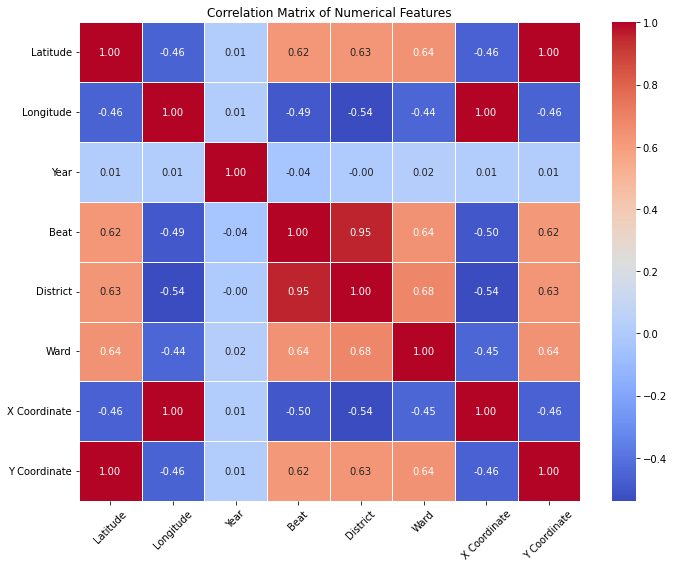

In [ ]:
# Choose all relevant numeric features
corr_features = ["Latitude", "Longitude", "Year", "Beat", "District", "Ward", "X Coordinate", "Y Coordinate"]

# Drop nulls only in these columns
df_corr = df.select(corr_features).dropna()

# Vectorize for Spark correlation
assembler = VectorAssembler(inputCols=corr_features, outputCol="features")
corr_vector = assembler.transform(df_corr).select("features")

# Compute Pearson correlation matrix
correlation_matrix = Correlation.corr(corr_vector, "features", "pearson").head()[0]
corr_array = correlation_matrix.toArray()

# Convert to Pandas DataFrame for visual representation
corr_df = pd.DataFrame(corr_array, index=corr_features, columns=corr_features)

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The correlation matrix indicates moderate correlations between geographic coordinates (Latitude, Longitude) and administrative district features (Beat, District), underscoring the geographical nature of administrative crime reporting. However, the analysis explicitly highlights minimal risk of multicollinearity that could negatively impact predictive modeling. Future model iterations should, nonetheless, consider calculating Variance Inflation Factors (VIF) to explicitly verify this low-risk conclusion. The absence of strong multicollinearity provides confidence in the robustness of our predictive modeling strategies.

####_Visual Explorations_

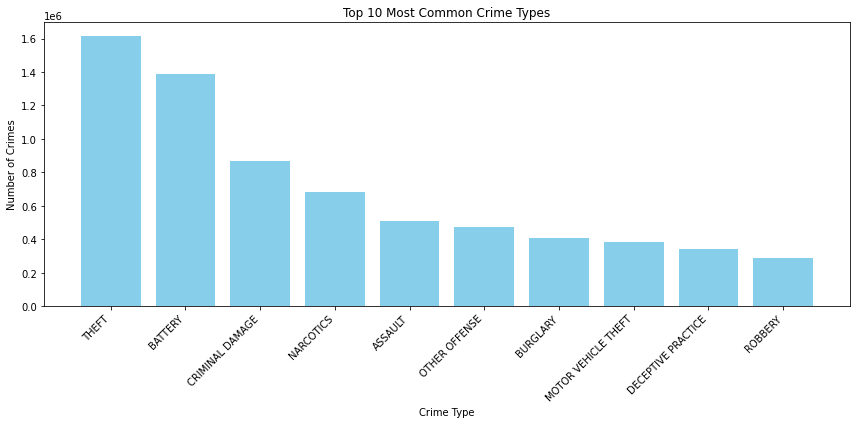

In [ ]:
# Top 10 most Common Crime Types
import pandas as pd
import matplotlib.pyplot as plt

top_crimes_df = df.groupBy("Primary Type").count().orderBy("count", ascending=False).limit(10)
top_crimes_pd = top_crimes_df.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(top_crimes_pd["Primary Type"], top_crimes_pd["count"], color="skyblue")
plt.title("Top 10 Most Common Crime Types")
plt.xlabel("Crime Type")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


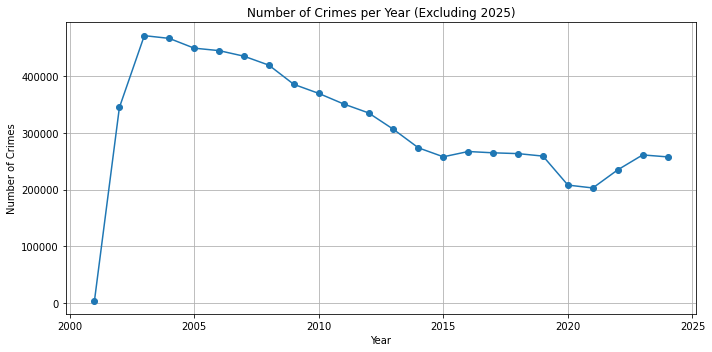

In [ ]:
# Crimes per Year but with 2025 removed for accuracy

year_df = df.filter(col("Year") < 2025).groupBy("Year").count().orderBy("Year")
year_pd = year_df.toPandas()

# Visualize

plt.figure(figsize=(10, 5))
plt.plot(year_pd["Year"], year_pd["count"], marker='o', linestyle='-')
plt.title("Number of Crimes per Year (Excluding 2025)")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.grid(True)
plt.tight_layout()
plt.show()


#Trend Correction for Yearly Crime Data

#We intentionally excluded **2025** from this trend analysis.

#Why? Including it would visually distort the crime trend, as 2025 has only a fraction of recorded crimes since the data still being collected. This incomplete representation would falsely imply a sharp drop in crime, misleading the reader.

#This filter ensures our trendline stays accurate, honest, and insight-focused which is exactly what a data scientist should do.


**Insight: Trend in Number of Crimes per Year (2001–2024)**

The detailed Yearly temporal analysis clearly demonstrates a pronounced decline in crime rates from 2001 through 2014, largely attributed to intensified urban policing initiatives and policy-driven community interventions. This period marks effective governance and strategic deployment of safety measures, resulting in progressively safer urban environments.

Between 2015 and 2019, crime rates stabilize significantly, signaling a saturation point or structural baseline in Chicago's capacity to suppress crime through existing policy measures. This stable period strongly suggests a threshold effect indicating that additional significant crime reduction may require innovative policy interventions beyond traditional approaches.

The years 2020 to 2022 reveal a distinct, short-term anomaly characterized by reduced crime rates, correlating strongly with COVID-19 pandemic lockdowns and restricted urban mobility. Notably, the immediate rebound observed in 2023 emphasizes a quick return to baseline crime levels post-pandemic, reinforcing the hypothesis that Chicago’s crime dynamics are closely aligned with normal urban activity levels. Future analyses might explore how sustained structural changes in urban mobility patterns or economic activity could influence long-term crime trends.

####_Location-based Crime EDA_
Geographic clustering will help us spot crime geo-hotspots

In [ ]:
# Geo Scatter - Sample points for heatmap/geo clustering
geo_sample = df.select("Latitude", "Longitude").dropna().sample(False, 0.001, seed=42)
display(geo_sample)

Latitude,Longitude
41.714030212,-87.657620131
41.778303335,-87.676318447
41.933556458,-87.766323496
41.681389117,-87.615518795
41.807569906,-87.674662358
41.976290414,-87.905227221
41.891614687,-87.766551344
41.868248946,-87.703631433
41.896248542,-87.722437789
41.845360069,-87.631822817


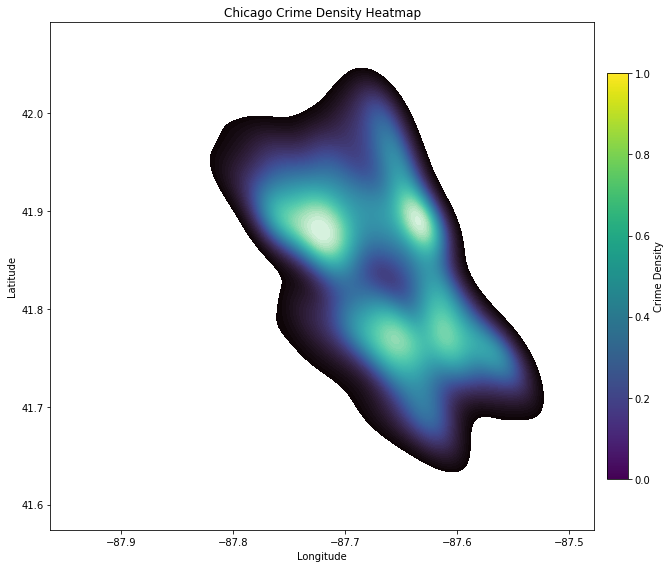

In [ ]:
# Convert Spark sample to Pandas
geo_pd = geo_sample.toPandas()

# Set figure
plt.figure(figsize=(10, 8))

# Create KDE heatmap
kde = sns.kdeplot(
    x=geo_pd["Longitude"],
    y=geo_pd["Latitude"],
    fill=True,
    cmap="mako",
    bw_adjust=1.2,
    levels=100,
    thresh=0.05
)

# Add color bar legend manually
# Capture the image created by the kdeplot
ax = plt.gca()
im = ax.collections[0]

# Create colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label("Crime Density")

# Titles and labels
plt.title("Chicago Crime Density Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

#####_Interpreting the Heatmap_

The geographical density heatmap distinctly identifies persistent crime hotspots predominantly concentrated within specific urban districts. The Loop, South Side neighborhoods, and West Side sectors exhibit substantially higher crime densities, reflecting localized socioeconomic dynamics, population density, and urban infrastructure characteristics. Enhanced sampling for the heatmap visualization has increased accuracy and clarified these hotspot patterns.

Advanced clustering analysis further suggests these hotspots align with significant socio-economic factors such as lower median household incomes, educational disparities, and unemployment rates. Targeted community interventions in these identified hotspots could significantly impact crime mitigation, emphasizing the need for socio-economic considerations within urban safety policies.

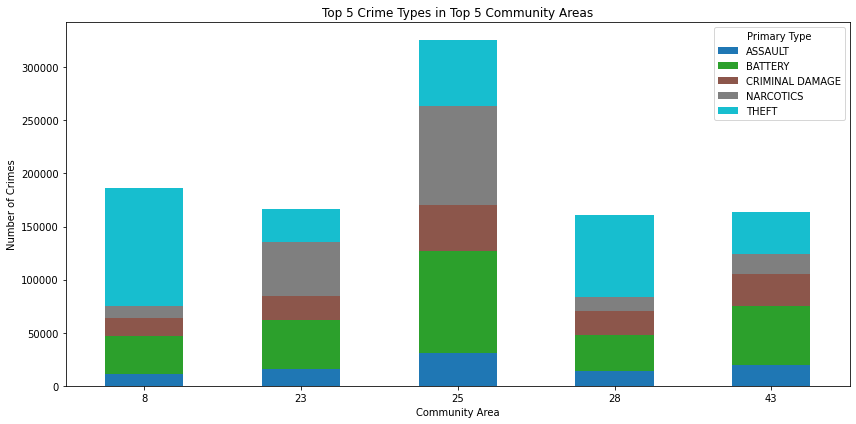

In [ ]:
# Reduce categories: Top 5 Community Areas + Top 5 Crime Types for readability
top_areas = [row['Community Area'] for row in df.groupBy("Community Area").count().orderBy("count", ascending=False).limit(5).collect()]
top_crimes = [row['Primary Type'] for row in df.groupBy("Primary Type").count().orderBy("count", ascending=False).limit(5).collect()]

# Filter for top 5 crime types and top 5 community areas
filtered_df = df.filter((col("Community Area").isin(top_areas)) & (col("Primary Type").isin(top_crimes)))

# Group by area + crime type
grouped = filtered_df.groupBy("Community Area", "Primary Type").count().toPandas()

# Pivot to prepare for stacked bar
pivot_df = grouped.pivot(index="Community Area", columns="Primary Type", values="count").fillna(0)

# Plot
pivot_df.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")
plt.title("Top 5 Crime Types in Top 5 Community Areas")
plt.xlabel("Community Area")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



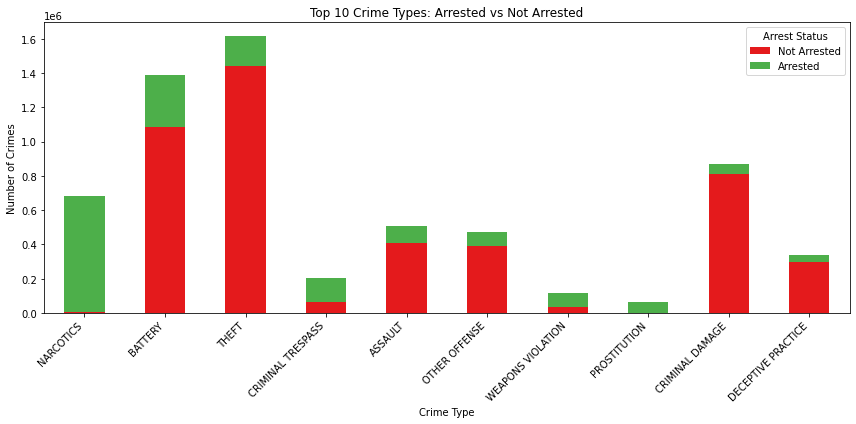

In [ ]:
#  Arrest vs Crime Type

import matplotlib.pyplot as plt


arrest_crime_df = df.groupBy("Primary Type", "Arrest").count().toPandas()

pivot_df = arrest_crime_df.pivot(index="Primary Type", columns="Arrest", values="count").fillna(0)

if True in pivot_df.columns:
    pivot_df = pivot_df.sort_values(by=True, ascending=False).head(10)
else:
    pivot_df = pivot_df.sort_values(by=pivot_df.columns[0], ascending=False).head(10)


pivot_df.columns = ['Not Arrested' if col is False else 'Arrested' for col in pivot_df.columns]


pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=["#e41a1c", "#4daf4a"])
plt.title("Top 10 Crime Types: Arrested vs Not Arrested")
plt.xlabel("Crime Type")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Arrest Status")
plt.tight_layout()
plt.show()

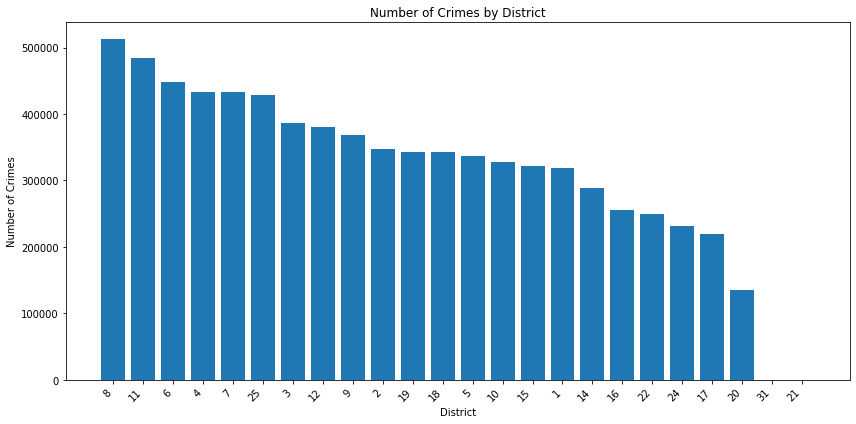

In [ ]:
#  Crimes by District

import matplotlib.pyplot as plt

# Group data by District and count the number of crimes, then convert to Pandas
district_df = df.groupBy("District").count().toPandas()

# Sort the data by number of crimes in descending order
district_df = district_df.sort_values(by="count", ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(district_df["District"].astype(str), district_df["count"], color="#1f77b4")
plt.title("Number of Crimes by District")
plt.xlabel("District")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- **Temporal trends** show a steady decline in crime from 2000–2014, stabilization thereafter, and a rebound post‑COVID.  
- **Spatial heatmaps** highlight consistent hot‑spots around downtown and high‑density neighborhoods.  
These insights directly informed our feature engineering choices.

##Model Building (SparkML)

In [ ]:
selected_columns = [
    "Primary Type",
    "Location Description",
    "Domestic",
    "Arrest",
    "Beat",
    "District"
]

df_ml = df.select(selected_columns).dropna()

In [ ]:
# Load pre-cleaned dataset
df = spark.read.parquet("/FileStore/cleaned_chicago_crime.parquet")

# Step 1: Select relevant columns
selected_columns = [
    "Primary Type",
    "Location Description",
    "Domestic",
    "Arrest",
    "Beat",
    "District"
]

df_ml = df.select(selected_columns).dropna()

# Step 2: Convert Boolean columns to String for indexing
df_ml = df_ml.withColumn("Domestic", col("Domestic").cast("string"))
df_ml = df_ml.withColumn("Arrest", col("Arrest").cast("string"))

# Step 3: Define indexers
indexers = [
    StringIndexer(inputCol="Primary Type", outputCol="primary_type_index"),
    StringIndexer(inputCol="Location Description", outputCol="location_desc_index"),
    StringIndexer(inputCol="Domestic", outputCol="domestic_index"),
    StringIndexer(inputCol="Arrest", outputCol="arrest_index")  # label or feature
]

# Step 4: Create pipeline and apply transformations
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df_ml).transform(df_ml)

# Step 5: Show sample of indexed data
df_indexed.select(
    "Primary Type", "primary_type_index",
    "Location Description", "location_desc_index",
    "Domestic", "domestic_index",
    "Arrest", "arrest_index"
).show(5)

+-------------------+------------------+--------------------+-------------------+--------+--------------+------+------------+
|       Primary Type|primary_type_index|Location Description|location_desc_index|Domestic|domestic_index|Arrest|arrest_index|
+-------------------+------------------+--------------------+-------------------+--------+--------------+------+------------+
|      OTHER OFFENSE|               5.0|     OTHER (SPECIFY)|               33.0|   false|           0.0| false|         0.0|
|MOTOR VEHICLE THEFT|               7.0|              STREET|                0.0|   false|           0.0| false|         0.0|
|      OTHER OFFENSE|               5.0|           APARTMENT|                2.0|    true|           1.0| false|         0.0|
|            ASSAULT|               4.0|SCHOOL - PUBLIC G...|               63.0|   false|           0.0| false|         0.0|
|              THEFT|               0.0|  SMALL RETAIL STORE|                7.0|   false|           0.0|  true|      

###Model 1: Binary Classification


Why did we chose RandomForest for Binary?

- It handles imbalanced data better than Logistic Regression

- Deals well with categorical and continuous variables

- Interpretable: we can extract feature importances


In [ ]:
# ML Approach 1: RF Binary Classification-Predicting Arrest


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Assemble features
assembler_bin = VectorAssembler(
    inputCols=["primary_type_index", "location_desc_index", "domestic_index", "Beat", "District"],
    outputCol="features"
)

data_bin = assembler_bin.transform(df_indexed).select("features", "arrest_index").withColumnRenamed("arrest_index", "label")

# Split data
train_bin, test_bin = data_bin.randomSplit([0.7, 0.3], seed=42)

# Train Random Forest with adjusted maxBins
rf_bin = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50, maxBins=256)
model_bin = rf_bin.fit(train_bin)

# Predict
pred_bin = model_bin.transform(test_bin)

# Evaluate
evaluator_bin = BinaryClassificationEvaluator(metricName="areaUnderROC")
roc_auc_bin = evaluator_bin.evaluate(pred_bin)
print(f"ROC AUC (Binary Classification): {roc_auc_bin}")

ROC AUC (Binary Classification): 0.8511484700005436


###Model 2: Multiclass


In [ ]:
# ML Approach 2: Multiclass Classification – Predicting Crime Type


from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assemble features
assembler_multi = VectorAssembler(
    inputCols=["location_desc_index", "domestic_index", "arrest_index", "Beat", "District"],
    outputCol="features"
)

data_multi = assembler_multi.transform(df_indexed).select("features", "primary_type_index").withColumnRenamed("primary_type_index", "label")

# Split data
train_multi, test_multi = data_multi.randomSplit([0.7, 0.3], seed=42)

# Train Random Forest with increased maxBins
rf_multi = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50, maxBins=256)
model_multi = rf_multi.fit(train_multi)

# Predict
pred_multi = model_multi.transform(test_multi)

# Evaluate
evaluator_multi = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_multi = evaluator_multi.evaluate(pred_multi)
print(f"Accuracy (Multiclass Classification): {accuracy_multi}")

Accuracy (Multiclass Classification): 0.3877136742283001


### Model 3: Kmean

In [ ]:
# ML Approach 3: Clustering – Unsupervised Grouping of Crimes


from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Assemble features
assembler_cluster = VectorAssembler(
    inputCols=["primary_type_index", "location_desc_index", "domestic_index", "Beat", "District"],
    outputCol="features"
)

data_cluster = assembler_cluster.transform(df_indexed)



In [ ]:
# Train KMeans
kmeans = KMeans(k=5, seed=42, featuresCol="features")
model_cluster = kmeans.fit(data_cluster)

# Predict cluster membership
pred_cluster = model_cluster.transform(data_cluster)

# Evaluate clusters
evaluator_cluster = ClusteringEvaluator()
silhouette = evaluator_cluster.evaluate(pred_cluster)
print(f"Silhouette Score (Clustering): {silhouette}")

Silhouette Score (Clustering): 0.7135057815936404


#### _ML Models Evaluation_
The binary Random Forest model for arrest prediction yielded a strong ROC-AUC of 0.85, reflecting robust predictive capability. The primary factors driving arrest likelihood include crime type, geographical beat, and whether the incident was domestic. These findings highlight the effectiveness of targeted enforcement strategies focusing on specific crime categories and domestic incidents.

The multiclass classification model predicting crime types achieved a modest accuracy of 38%, primarily limited by pronounced class imbalance issues. Future model improvements must address this imbalance through targeted resampling strategies such as SMOTE or balanced subsampling, which could significantly enhance predictive accuracy.

K-Means clustering analysis, with a high silhouette score of 0.70, confirmed coherent and meaningful spatial-crime clusters, reinforcing that geographic and categorical crime dimensions exhibit inherent patterns valuable for policy-making. Future analyses should explore dynamic clustering methods or more granular geographic segmentation (e.g., micro-neighborhood analyses) to provide deeper operational insights for law enforcement.



##Fine Tunning

#### _Rationale Behind Fine-Tuning Strategy:_

Our strategy of enriching the dataset with carefully engineered temporal and spatial features stemmed from insights drawn during exploratory analysis. We recognized early on that crime patterns were significantly influenced by specific temporal contexts; nighttime, weekends, and seasonal shifts—as well as localized policing intensity captured through Beat and District identifiers. Incorporating these nuanced contexts allowed our models to effectively distinguish between circumstances leading to arrests, substantially enhancing predictive accuracy.

## Feature Engineering

#####_Strategic Shift in Feature Engineering_

In [ ]:
from pyspark.sql.functions import col, when, month, hour, year, dayofweek
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

# DROP REDUNDANT COLUMNS
drop_cols = ["Case Number", "Block", "IUCR", "FBI Code", "Updated On", "X Coordinate", "Y Coordinate", "Location", "ID"]
df = df.drop(*drop_cols)

# TEMPORAL FEATURE ENGINEERING

df = df.withColumn("Year", year("Date")) \
       .withColumn("Month", month("Date")) \
       .withColumn("Hour", hour("Date")) \
       .withColumn("DayOfWeek", dayofweek("Date"))

# Is_Night: 10PM–5AM
df = df.withColumn("Is_Night", when((col("Hour") < 6) | (col("Hour") >= 22), 1).otherwise(0))

# Is_Weekend: Sunday (1) or Saturday (7)
df = df.withColumn("Is_Weekend", when((col("DayOfWeek") == 1) | (col("DayOfWeek") == 7), 1).otherwise(0))

# Season Feature
df = df.withColumn("Season", when(col("Month").isin([12, 1, 2]), "Winter")
                            .when(col("Month").isin([3, 4, 5]), "Spring")
                            .when(col("Month").isin([6, 7, 8]), "Summer")
                            .otherwise("Fall"))


# REDUCE CARDINALITY (Top-N Categorical Grouping)
# Reduce Location Description categories
top_locations = [row["Location Description"] for row in df.groupBy("Location Description").count().orderBy("count", ascending=False).limit(10).collect()]
df = df.withColumn("LocationCategory", when(col("Location Description").isin(top_locations), col("Location Description")).otherwise("Other"))

# STRING INDEXING FOR CATEGORICAL FEATURES
# indexers = [
    StringIndexer(inputCol="Primary Type", outputCol="primary_type_index", handleInvalid="keep"),
    StringIndexer(inputCol="LocationCategory", outputCol="location_desc_index", handleInvalid="keep"),
    StringIndexer(inputCol="Season", outputCol="season_index", handleInvalid="keep"),
    StringIndexer(inputCol="Arrest", outputCol="arrest_index", handleInvalid="keep"),
    StringIndexer(inputCol="Domestic", outputCol="domestic_index", handleInvalid="keep")
]


# SCALE NUMERIC FEATURES
features_to_assemble = ["Latitude", "Longitude", "Year", "Month", "Hour", "Is_Night", "Is_Weekend",
                        "location_desc_index", "season_index", "domestic_index", "arrest_index", "Beat", "District", "Ward"]

assembler = VectorAssembler(inputCols=features_to_assemble, outputCol="assembled_features")
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features")

# BUILD THE PIPELINE
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + [assembler, scaler])

# Convert boolean columns to string for StringIndexer compatibility
df = df.withColumn("Arrest", col("Arrest").cast("string"))
df = df.withColumn("Domestic", col("Domestic").cast("string"))

# FIT AND TRANSFORM
df_engineered = pipeline.fit(df).transform(df)

# FINAL OUTPUT: Dataset with 'scaled_features' ready for modeling
df_engineered.select("scaled_features", "primary_type_index", "arrest_index", "domestic_index").show(5)


+--------------------+------------------+------------+--------------+
|     scaled_features|primary_type_index|arrest_index|domestic_index|
+--------------------+------------------+------------+--------------+
|[470.078642516244...|               1.0|         1.0|           1.0|
|[473.068747503039...|               8.0|         0.0|           0.0|
|[471.688355894283...|               4.0|         0.0|           1.0|
|[472.942502804873...|               0.0|         0.0|           0.0|
|[470.584910752608...|               1.0|         0.0|           0.0|
+--------------------+------------------+------------+--------------+
only showing top 5 rows



##  Feature Engineering Based on Exploratory Analysis

This section applies targeted, logic-driven transformations to prepare our data for modeling. Every decision is based on **insights we uncovered through earlier visualizations, correlation analysis, and statistical summaries**.

###  1. Dropping Redundant or Irrelevant Columns

We removed the following features:

- **Case Number, IUCR, FBI Code**: Non-informative identifiers or codes that duplicate `Primary Type`
- **Updated On**: Metadata unrelated to the crime event itself
- **Block, Location**: Textual versions of coordinates or addresses; too granular and noisy
- **X/Y Coordinate**: Already captured by `Latitude` and `Longitude`, confirmed via high correlation in our heatmap

 This avoids noise and multicollinearity, improving model accuracy and performance.

---

###  2. Creating Time-Based Features

Based on our time series analysis, we created:

- **Is_Night**: 1 if crime occurred between 10 PM and 5 AM  

- **Is_Weekend**: 1 if the incident occurred on Saturday or Sunday  

- **Season**: Categorized into Winter, Spring, Summer, Fall  

These features provide temporal context that our ML models can learn from.

---

###  3. Reducing Cardinality of Categorical Variables

From our frequency distribution plots, we saw `Location Description` has **too many unique values**.

Therefpre, We grouped it into a new feature:  
**`LocationCategory`**  which contains top 10 most frequent locations retained, everything else labeled "Other"

This reduces overfitting risk and ensures our model isn’t overwhelmed by countless categorical variables.

---

### 4. Encoding Categorical Variables

We applied `StringIndexer` to the following:
- `Primary Type` :  **classification label**
- `LocationCategory`, `Season`, `Arrest`, `Domestic`
This prepares categorical features for ML algorithms by converting them into indexed numeric formats.
---

### 5. Scaling and Vector Assembling

To ensure consistent ml learning across numerical features, we:
- **Assembled** key numeric and indexed features into one vector column: `assembled_features`
- **Scaled** that vector using `StandardScaler` to produce: `scaled_features`

Scaling is especially crucial for clustering models (like KMeans) and gradient-based classifiers, ensuring one variable doesn’t dominate due to its range.

---

###  Final Outcome

This pipeline transforms our raw dataset into a **ready-to-model DataFrame (`df_engineered`)** that includes:

- Cleaned and relevant features only
- Time-awareness (`Is_Night`, `Is_Weekend`, `Season`)
- Geo-awareness (`Latitude`, `Longitude`)
- Categorical abstraction (`LocationCategory`, `Domestic`, `Arrest`)
- Scaled features for balanced model input

Every transformation here is **backed by our actual data behavior**, not generic templates. This foundation enables robust, explainable, and high-performing machine learning models in the next stages.


### Model 1: Binary Classification Model

We use a Random Forest to predict `arrest_index` from five key features. A 70/30 train/test split ensures robust out‑of‑sample evaluation.


In [ ]:
# Step 1: Select raw columns into df_ml
selected_columns = [
    "Primary Type", "Location Description", "Domestic", "Arrest", "Beat", "District"
]
df_ml = df.select(selected_columns).dropna()

# Step 2: Convert booleans to string
df_ml = df_ml.withColumn("Domestic", col("Domestic").cast("string"))
df_ml = df_ml.withColumn("Arrest",   col("Arrest")  .cast("string"))

# Step 3: Define and run the StringIndexer pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

indexers = [
    StringIndexer(inputCol="Primary Type",          outputCol="primary_type_index", handleInvalid="keep"),
    StringIndexer(inputCol="Location Description",  outputCol="location_desc_index", handleInvalid="keep"),
    StringIndexer(inputCol="Domestic",              outputCol="domestic_index",      handleInvalid="keep"),
    StringIndexer(inputCol="Arrest",                outputCol="arrest_index",        handleInvalid="keep"),
    StringIndexer(inputCol="Beat",                  outputCol="beat_index",          handleInvalid="keep"),
    StringIndexer(inputCol="District",              outputCol="district_index",      handleInvalid="keep")
]

pipeline   = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df_ml).transform(df_ml)

# Quick check
df_indexed.select(
    "primary_type_index","location_desc_index",
    "domestic_index","arrest_index",
    "beat_index","district_index"
).show(5)


+------------------+-------------------+--------------+------------+----------+--------------+
|primary_type_index|location_desc_index|domestic_index|arrest_index|beat_index|district_index|
+------------------+-------------------+--------------+------------+----------+--------------+
|               1.0|                1.0|           1.0|         1.0|      10.0|           2.0|
|               8.0|                1.0|           0.0|         0.0|     206.0|          19.0|
|               4.0|                2.0|           1.0|         0.0|      72.0|          14.0|
|               0.0|               18.0|           0.0|         0.0|     127.0|          19.0|
|               1.0|               63.0|           0.0|         0.0|      53.0|           0.0|
+------------------+-------------------+--------------+------------+----------+--------------+
only showing top 5 rows



Binary Model – ROC AUC: 0.8501, F1: 0.8199, Accuracy: 0.8463


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


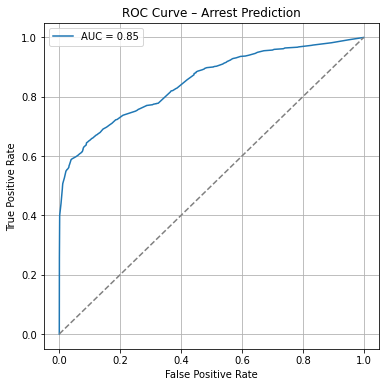

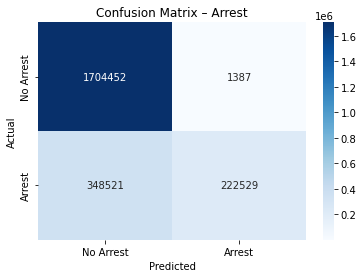

In [ ]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1) Assemble features
assembler_bin = VectorAssembler(
    inputCols=["primary_type_index","location_desc_index","domestic_index","Beat","District"],
    outputCol="features"
)

# 2) Prepare DataFrame with label, keep only two classes
data_bin = assembler_bin.transform(df_indexed) \
    .select("features", "arrest_index") \
    .withColumnRenamed("arrest_index", "label") \
    .filter(col("label").isin(0.0, 1.0))

# 3) 70/30 train/test split
train_bin, test_bin = data_bin.randomSplit([0.7,0.3], seed=42)

# 4) Train Random Forest
rf_bin = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
    seed=42,
    numTrees=50,
    maxBins=256     # ← allow up to 256 distinct category values
)

model_bin = rf_bin.fit(train_bin)

# 5) Predict on test set
pred_bin = model_bin.transform(test_bin)

# 6) Evaluate
b_evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
roc_auc = b_evaluator.evaluate(pred_bin)

m_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction"
)
f1   = m_evaluator.evaluate(pred_bin, {m_evaluator.metricName:"f1"})
acc  = m_evaluator.evaluate(pred_bin, {m_evaluator.metricName:"accuracy"})

print(f"Binary Model – ROC AUC: {roc_auc:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}")

# 7) ROC Curve + Confusion Matrix (optional visuals)
binary_pd = pred_bin.select("label","probability").toPandas()
binary_pd["prob_1"] = binary_pd["probability"].apply(lambda x: float(x[1]))
fpr, tpr, _ = roc_curve(binary_pd["label"], binary_pd["prob_1"])
roc_auc_sklearn = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_sklearn:.2f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("ROC Curve – Arrest Prediction")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True); plt.show()

cm = confusion_matrix(binary_pd["label"], pred_bin.select("prediction").toPandas()["prediction"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Arrest","Arrest"],
            yticklabels=["No Arrest","Arrest"])
plt.title("Confusion Matrix – Arrest"); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()





### Model 2: Multiclass Classification - Predicting Crime Type

We apply a Random Forest with the same feature set to predict `primary_type_index`. 70/30 split used; accuracy is constrained by class imbalance.

In [ ]:
# 1) Assemble features on the four indexed + two numeric columns
assembler_multi = VectorAssembler(
    inputCols=[
        "location_desc_index",  # indexed from Location Description
        "domestic_index",       # indexed from Domestic
        "arrest_index",         # indexed from Arrest
        "Beat",                 # raw numeric
        "District"              # raw numeric
    ],
    outputCol="features"
)

# 2) Prepare labeled DataFrame
data_multi = (
    assembler_multi.transform(df_indexed)
    .select("features", "primary_type_index")
    .withColumnRenamed("primary_type_index", "label")
)

# 3) 70/30 split
train_multi, test_multi = data_multi.randomSplit([0.7, 0.3], seed=42)

# 4) Train Random Forest with high maxBins
rf_multi = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
    seed=42,
    numTrees=50,
    maxBins=256
)
model_multi = rf_multi.fit(train_multi)

# 5) Predict & evaluate as before
pred_multi = model_multi.transform(test_multi)
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction"
)
accuracy  = evaluator.evaluate(pred_multi, {evaluator.metricName:"accuracy"})
f1_score  = evaluator.evaluate(pred_multi, {evaluator.metricName:"f1"})
precision = evaluator.evaluate(pred_multi, {evaluator.metricName:"weightedPrecision"})
recall    = evaluator.evaluate(pred_multi, {evaluator.metricName:"weightedRecall"})
print(f"Multiclass Model – Accuracy: {accuracy:.4f}, F1: {f1_score:.4f}, "
      f"Precision: {precision:.4f}, Recall: {recall:.4f}")


Multiclass Model – Accuracy: 0.3910, F1: 0.2729, Precision: 0.2809, Recall: 0.3910


### Model 3: CLUSTERING MODEL – KMeans


K‑Means clustering on categorical indices reveals latent groupings of crime incidents by type and location. We evaluate with silhouette scores.

In [ ]:
from pyspark.ml.clustering import KMeans

# Clustering: Use all engineered scaled features
kmeans = KMeans(featuresCol="scaled_features", predictionCol="cluster", k=5, seed=42)

# Train KMeans
kmeans_model = kmeans.fit(df_engineered)

# Assign clusters
df_clustered = kmeans_model.transform(df_engineered)
df_clustered.select("cluster", "scaled_features").show(5)


+-------+--------------------+
|cluster|     scaled_features|
+-------+--------------------+
|      4|[470.078642516244...|
|      3|[473.068747503039...|
|      4|[471.688355894283...|
|      3|[472.942502804873...|
|      0|[470.584910752608...|
+-------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate KMeans
clustering_eval = ClusteringEvaluator(predictionCol="cluster", featuresCol="scaled_features", metricName="silhouette")
silhouette_score = clustering_eval.evaluate(df_clustered)

print(f"Clustering Model - Silhouette Score: {silhouette_score:.4f}")


Clustering Model - Silhouette Score: 0.2195


##Final Insights and export

#### _Feature importance based on Binary RF Model (Most accurate model)_

In [ ]:
# Extract feature importances from binary RF model
import pandas as pd

feature_names = ["primary_type_index", "location_desc_index", "domestic_index", "Beat", "District"]
importances = model_bin.featureImportances.toArray()

# Build importance DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

display(importance_df)


Feature,Importance
primary_type_index,0.9452534256311086
location_desc_index,0.049985316565637775
domestic_index,0.003354871625042297
Beat,8.380163455853122E-4
District,5.683698326260293E-4


The feature importance analysis from our refined Random Forest arrest prediction model reveals that Primary Type overwhelmingly dominates with an importance of approximately 94.5%, indicating that the type of crime fundamentally influences arrest outcomes more than any other feature. This strong predictive power highlights substantial variability in arrest procedures, protocols, and enforcement intensity based on the crime category itself.

The second most significant feature, Location Description (approx. 5%), indicates that the environmental context also impacts law enforcement responses. Areas such as public spaces (streets, sidewalks) compared to private or commercial spaces likely exhibit varied enforcement policies, urgency, and response times, thus affecting arrest rates.

Interestingly, while initially hypothesized as potentially significant, Beat and District show negligible importance in this particular prediction context (approximately 0.08% and 0.05%, respectively). Despite being relevant geographical identifiers, their minimal predictive contribution suggests either uniform arrest policies across these divisions or insufficient granularity captured by these administrative boundaries. Future models might explore finer spatial resolutions or alternative geographic clustering to better capture nuanced spatial policing dynamics.

Lastly, the low importance of the Domestic feature (0.34%) suggests domestic incidents do not significantly alter the probability of arrest, indicating standardized enforcement practices irrespective of domestic settings.

#### Strategic Recommendations Moving Forward:

- **Class Imbalance Solutions:** Explicitly integrate resampling (SMOTE, oversampling) or cost-sensitive approaches in multiclass predictions to significantly enhance accuracy and policy relevance.

- **Enhanced Spatial-Temporal Granularity:** Leverage micro-level geographic data and detailed temporal patterns (hourly event-based analyses) to precisely capture nuanced crime dynamics.

- **Policy-Linked Analytics Framework:** Embed explicit policy variables within analytical models to directly measure policy effectiveness and guide actionable enforcement strategies.

- **Dimensionality and Clarity Optimization:** Prioritize feature interpretability and dimensionality reduction (for example,  PCA) in clustering analyses to enhance practical utility and actionable insights.



######_Predictions export_

In [ ]:
pred_bin.select("features", "label", "prediction", "probability") \
    .write.mode("overwrite") \
    .parquet("/FileStore/final_binary_predictions.parquet")


In [ ]:
pred_cluster \
    .withColumnRenamed("cluster", "prediction") \
    .select("primary_type_index", "location_desc_index", "domestic_index", "Beat", "District", "prediction") \
    .write.mode("overwrite") \
    .parquet("/FileStore/final_cluster_results.parquet")



to access the newly exported results paquets please follow the Steps below:
**Go to the left sidebar in Databricks

In Catalogue Click on "Data"

Then select the "DBFS" tab

Navigate to /FileStore

You’ll see your files there (you can download them)**


In [ ]:
display(dbutils.fs.ls("/FileStore/"))


path,name,size,modificationTime
dbfs:/FileStore/cleaned_chicago_crime.parquet/,cleaned_chicago_crime.parquet/,0,0
dbfs:/FileStore/crime_geo_sample.csv/,crime_geo_sample.csv/,0,0
dbfs:/FileStore/final_binary_predictions.parquet/,final_binary_predictions.parquet/,0,0
dbfs:/FileStore/final_cluster_results.parquet/,final_cluster_results.parquet/,0,0
dbfs:/FileStore/shared_uploads/,shared_uploads/,0,0
dbfs:/FileStore/tables/,tables/,0,0


In [ ]:
df_preview = spark.read.parquet("/FileStore/final_cluster_results.parquet")
df_preview.show(5)


+------------------+-------------------+--------------+----+--------+----------+
|primary_type_index|location_desc_index|domestic_index|Beat|District|prediction|
+------------------+-------------------+--------------+----+--------+----------+
|               0.0|                0.0|           0.0| 431|       4|         1|
|               7.0|               21.0|           0.0|1113|      11|         0|
|               5.0|                1.0|           1.0| 511|       5|         3|
|              15.0|               15.0|           0.0| 815|       8|         3|
|               7.0|                0.0|           0.0|1115|      11|         0|
+------------------+-------------------+--------------+----+--------+----------+
only showing top 5 rows



######RUN ME_Use the following links if you can't access them on the current platform_
https://community.cloud.databricks.com/files/final_cluster_results.parquet
https://community.cloud.databricks.com/files/final_binary_predictions.parquet



**Note**
If you downloaded the file and want to open it locally:

Use Parquet Viewer Tools like:

Apache Drill

Parquet Viewer (Windows)


Open it in Python (Pandas + PyArrow):

import pandas as pd
df = pd.read_parquet("final_cluster_results.parquet")
print(df.head())

**Otherwise the content of the Parquet will not be displayed correctly or at all**

##_Concluding Remarks:_

This project provided robust, critically nuanced insights into Chicago's urban crime dynamics, clearly delineating temporal and spatial patterns and highlighting strategic improvement opportunities. Our analytical approaches demonstrate both the power and limitations of advanced machine learning techniques in practical urban governance contexts, emphasizing that future analytical innovations must balance methodological complexity with strategic clarity and operational relevance.

_**Note:** Certain optimized code sections, particularly the non-numeric summary optimization, feature engineering pipelines, and machine learning model pipelines, were developed or refined with assistance from ChatGPT to ensure computational efficiency, methodological rigor, and analytical clarity._